In [26]:
import pandas as pd

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [27]:
print(df.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [29]:
non_float_cols = [c for c in df.columns if df[c].dtype != 'float64']
max_len = max(len(c) for c in non_float_cols)
for col in non_float_cols:
    print(f"{col.ljust(max_len)} : {df[col].unique()}")

id             : [ 9046 51676 31112 ... 19723 37544 44679]
gender         : ['Male' 'Female' 'Other']
hypertension   : [0 1]
heart_disease  : [1 0]
ever_married   : ['Yes' 'No']
work_type      : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke         : [1 0]


In [30]:
df['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [31]:
df.isna().any(axis=0)

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [32]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=0
  )

cat_col = [
    'gender', 
    'ever_married', 
    'work_type', 
    'Residence_type', 
    'smoking_status'
  ]
num_col = [
    'age', 
    'avg_glucose_level', 
    'bmi'
  ]

preprocessor = ColumnTransformer([
    ('cat', 
      OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
      cat_col),
    ('num', 
      Pipeline([
        ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('ss', StandardScaler())
      ]), 
      num_col)
  ], 
  remainder='passthrough', 
  verbose_feature_names_out=False
)
preprocessor.set_output(transform='pandas')

X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

In [34]:
pd.concat(
  [
    X_train_p.isna().any(axis=0).rename('Training Set NaN'),
    X_test_p.isna().any(axis=0).rename('Testing Set NaN')
  ],
  axis=1,
  ignore_index=False
) 

,Training Set NaN,Testing Set NaN
gender_Female,False,False
gender_Male,False,False
ever_married_No,False,False
ever_married_Yes,False,False
work_type_Govt_job,False,False
work_type_Never_worked,False,False
work_type_Private,False,False
work_type_Self-employed,False,False
work_type_children,False,False
Residence_type_Rural,False,False


In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=0)
X_train_bal, y_train_bal = smote.fit_resample(X_train_p, y_train)
print(y_train_bal.value_counts())
print(y_test.value_counts())

stroke
0    3889
1    3889
Name: count, dtype: int64
stroke
0    972
1     50
Name: count, dtype: int64


In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def eval_model(name, estimator):
  pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=0)),
    ('clf', estimator)
  ])
  metrics = ['accuracy', 'precision', 'recall']

  result = cross_validate(pipeline, X_train_p, y_train, cv=cv, scoring=metrics, n_jobs=-1)

  print(f"\n=== {name} CV results ===")
  for metric in metrics:
    scores = result[f'test_{metric}']
    print(f"{metric:>9}: {scores.mean():.3f} ± {scores.std():.3f}")

  y_pred = cross_val_predict(pipeline, X_train_p, y_train, cv=cv, n_jobs=-1)
  
  ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
  plt.title(f"{name} CV Confusion Matrix")
  plt.show()


=== Random Forest CV results ===
 accuracy: 0.915 ± 0.010
precision: 0.124 ± 0.054
   recall: 0.116 ± 0.040


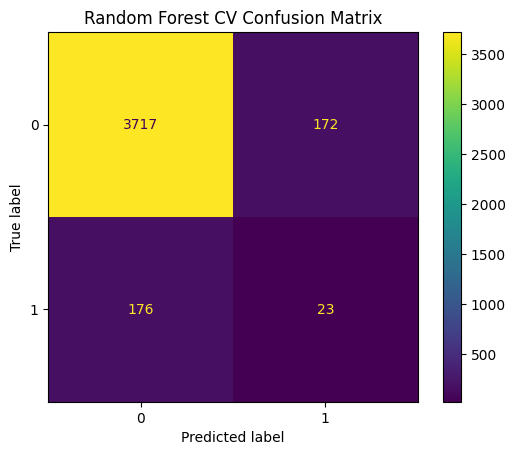


=== Gradient Boosting CV results ===
 accuracy: 0.857 ± 0.009
precision: 0.164 ± 0.018
   recall: 0.473 ± 0.071


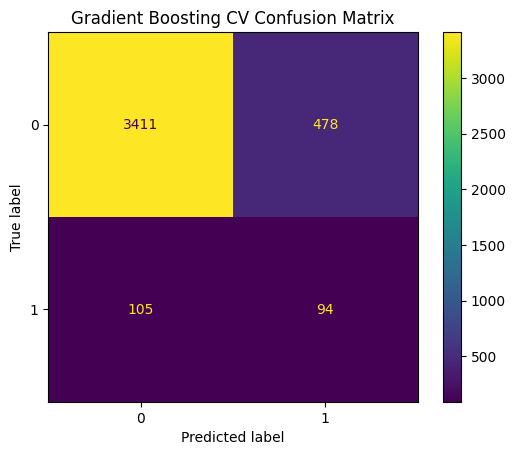

In [58]:
eval_model('Random Forest', RandomForestClassifier(random_state=0))
eval_model('Gradient Boosting', GradientBoostingClassifier(random_state=0))

In [59]:
from sklearn.feature_selection import RFE

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
metrics = ['accuracy', 'precision', 'recall']

def eval_rfe(name, estimator, n_features=5):
  pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=0)),
    ('rfe', RFE(estimator, n_features_to_select=n_features, step=1)),
    ('clf', estimator)
  ])

  result = cross_validate(pipeline, X_train_p, y_train, cv=cv, scoring=metrics, n_jobs=-1, return_estimator=True)

  print(f"\n=== {name} CV results ===")
  for metric in metrics:
    scores = result[f'test_{metric}']
    print(f"{metric:>9}: {scores.mean():.3f} ± {scores.std():.3f}")

  y_pred = cross_val_predict(pipeline, X_train_p, y_train, cv=cv, n_jobs=-1)
  
  ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
  plt.title(f"{name} CV Confusion Matrix")
  plt.show()

  best_fold = np.argmax(result['test_recall'])
  best_rfe = result['estimator'][best_fold].named_steps['rfe']
  print(f"{name} → best 5 features (fold #{best_fold}):")
  print(X_train_p.columns[best_rfe.support_].tolist(), '\n')

  return best_rfe


=== Random Forest with RFE CV results ===
 accuracy: 0.864 ± 0.006
precision: 0.140 ± 0.024
   recall: 0.357 ± 0.096


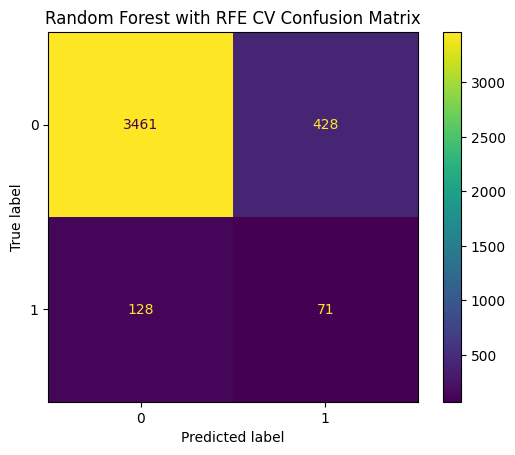

Random Forest with RFE → best 5 features (fold #3):
['ever_married_No', 'ever_married_Yes', 'age', 'avg_glucose_level', 'bmi'] 


=== Gradient Boosting with RFE CV results ===
 accuracy: 0.814 ± 0.006
precision: 0.141 ± 0.018
   recall: 0.558 ± 0.083


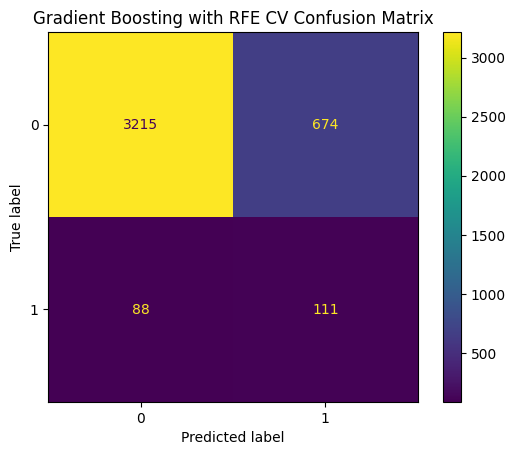

Gradient Boosting with RFE → best 5 features (fold #2):
['work_type_Govt_job', 'smoking_status_Unknown', 'age', 'avg_glucose_level', 'bmi'] 



In [60]:
rf_selector = eval_rfe('Random Forest with RFE', RandomForestClassifier(random_state=0))
gb_selector = eval_rfe('Gradient Boosting with RFE', GradientBoostingClassifier(random_state=0))

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
Best CV recall: 0.7991025641025641
Test Accuracy : 0.738747553816047
Test Precision: 0.1245674740484429
Test Recall   : 0.72


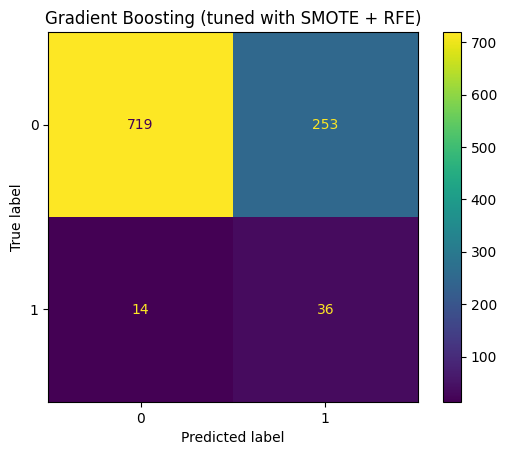

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=0)),
    ('feature_selection', gb_selector), 
    ('clf', GradientBoostingClassifier(random_state=0))
])

param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__max_features': [None, 'sqrt', 0.8],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 3, 5]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_p, y_train)

print("Best params:", grid.best_params_)
print("Best CV recall:", grid.best_score_)

y_pred = grid.predict(X_test_p)

print("Test Accuracy :", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall   :", recall_score(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title("Gradient Boosting (tuned with SMOTE + RFE)"); 
plt.show()

In [66]:
import pickle
pickle.dump(grid.best_estimator_.named_steps['clf'], open('model.pkl', 'wb'))